In [30]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
con = duckdb.connect()


In [32]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


In [33]:
DOSE_MAPPING = {
    4917: '5 mg/kg',
    4921: '5 mg/kg',
    4925: '5 mg/kg',
    4918: 'Vehicle',
    4922: 'Vehicle',
    4923: 'Vehicle',
    4919: '25 mg/kg',
    4920: '25 mg/kg',
    4924: '25 mg/kg',
}

In [34]:
# Corrected injection times (assuming data is in UTC)
INJECTION_REP1_DOSE1 = pd.Timestamp('2025-01-14 11:00:00')  # 6 AM EST → 11 AM UTC
INJECTION_REP1_DOSE2 = pd.Timestamp('2025-01-17 22:00:00')  # 5 PM EST → 10 PM UTC
INJECTION_REP2_DOSE1 = pd.Timestamp('2025-01-28 22:00:00')  # 5 PM EST → 10 PM UTC
INJECTION_REP2_DOSE2 = pd.Timestamp('2025-01-31 11:00:00')  # 6 AM EST → 11 AM UTC

In [35]:
# We'll analyze Dose 1 first (January 14, 6:00 AM)
INJECTION_TIME = INJECTION_REP1_DOSE1
INJECTION_DATE = '2025-01-14'


In [36]:
S3_BASE = 's3://jax-envision-public-data/study_1001/2025v3.3/tabular'

print("Study Configuration:")
print(f"  Injection time: {INJECTION_TIME}")
print(f"  Injection date: {INJECTION_DATE}")
print("\nCage Assignments:")
for dose in ['Vehicle', '5 mg/kg', '25 mg/kg']:
    cages = [c for c, d in DOSE_MAPPING.items() if d == dose]
    print(f"  {dose}: {cages}")

Study Configuration:
  Injection time: 2025-01-14 11:00:00
  Injection date: 2025-01-14

Cage Assignments:
  Vehicle: [4918, 4922, 4923]
  5 mg/kg: [4917, 4921, 4925]
  25 mg/kg: [4919, 4920, 4924]


In [37]:
con = duckdb.connect()


In [38]:
def load_cage_data(cage_id, date_str, file_type='animal_activity_db'):
    """Load parquet data for a specific cage and date."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    query = f"SELECT * FROM read_parquet('{path}')"
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = DOSE_MAPPING[cage_id]
        print(f"  ✓ Cage {cage_id} ({DOSE_MAPPING[cage_id]}): {len(df):,} rows")
        return df
    except Exception as e:
        print(f"  ✗ Cage {cage_id}: {e}")
        return pd.DataFrame()

In [39]:
dfs = []
for cage_id in DOSE_MAPPING.keys():
    df = load_cage_data(cage_id, INJECTION_DATE, 'animal_activity_db')
    if not df.empty:
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print("-" * 50)
print(f"Total rows loaded: {len(df_all):,}")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4917 (5 mg/kg): 913,545 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4921 (5 mg/kg): 928,620 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4925 (5 mg/kg): 935,655 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4918 (Vehicle): 849,024 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4922 (Vehicle): 839,778 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4923 (Vehicle): 767,217 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4919 (25 mg/kg): 942,690 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4920 (25 mg/kg): 1,005,804 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  ✓ Cage 4924 (25 mg/kg): 916,761 rows
--------------------------------------------------
Total rows loaded: 8,099,094


In [40]:
print("\nColumn names:")
print(df_all.columns.tolist())

print("\nData types:")
print(df_all.dtypes)

print("\nUnique metrics available (name column):")
print(df_all['name'].value_counts())

print("\nResolutions available:")
print(df_all['resolution'].value_counts())


Column names:
['predicted_identity', 'time', 'resolution', 'name', 'value', 'units', 'version_str', 'organization_id', 'cage_id', 'study_id', 'device_id', 'run_id', 'animal_id', 'ULID', '__index_level_0__', 'filename', 'source_file', 'date', 'dose_group']

Data types:
predicted_identity            object
time                  datetime64[ns]
resolution                     int64
name                          object
value                        float64
units                         object
version_str                   object
organization_id                int64
cage_id                        int64
study_id                       int64
device_id                     object
run_id                        object
animal_id                      int64
ULID                          object
__index_level_0__              int64
filename                      object
source_file                   object
date                  datetime64[us]
dose_group                    object
dtype: object

Unique metri

In [41]:
df_loco = df_all[
    (df_all['name'] == 'animal_bouts.locomotion') & 
    (df_all['resolution'] == 60)
].copy()

In [42]:
print(f"Locomotion data rows: {len(df_loco):,}")
print(f"Time range: {df_loco['time'].min()} to {df_loco['time'].max()}")
print(f"Animals per dose group:")
print(df_loco.groupby('dose_group')['animal_id'].nunique())

Locomotion data rows: 26,355
Time range: 2025-01-14 00:00:00 to 2025-01-14 23:59:00
Animals per dose group:
dose_group
25 mg/kg    9
5 mg/kg     9
Vehicle     9
Name: animal_id, dtype: int64


In [43]:
# Convert time to datetime and compute minutes from injection
df_loco['time'] = pd.to_datetime(df_loco['time'])
df_loco['minutes_from_injection'] = (df_loco['time'] - INJECTION_TIME).dt.total_seconds() / 60


In [44]:
# Filter to window of interest: 2 hours before to 4 hours after, might need to adjust based on actual data range
HOURS_BEFORE = 2
HOURS_AFTER = 8

In [45]:
df_loco = df_loco[
    (df_loco['minutes_from_injection'] >= -HOURS_BEFORE * 60) &
    (df_loco['minutes_from_injection'] <= HOURS_AFTER * 60)
]

In [46]:
print(f"\nAfter time filtering: {len(df_loco):,} rows")
print(f"Time range: {df_loco['minutes_from_injection'].min():.0f} to {df_loco['minutes_from_injection'].max():.0f} minutes")



After time filtering: 11,673 rows
Time range: -120 to 480 minutes


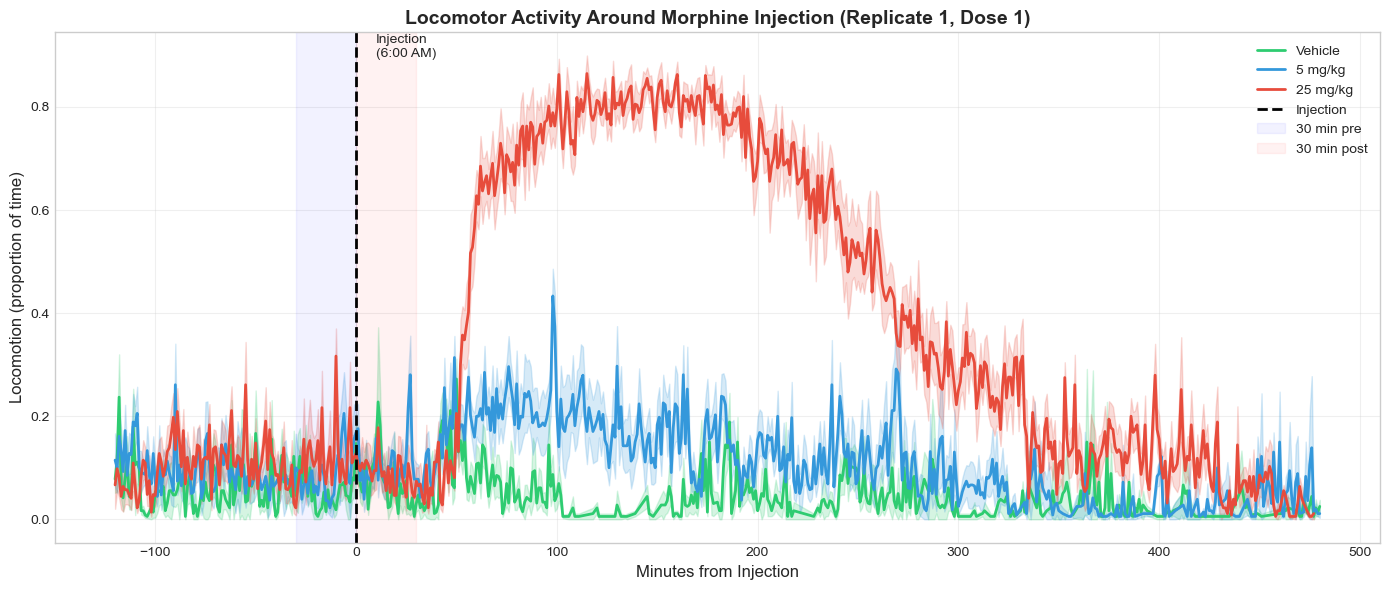

In [47]:
# ## Plot 1: Locomotor Activity by Dose Group (Mean ± SEM)
# 
# This is the key plot showing the morphine effect over time.

# %%
def plot_locomotor_by_dose(df, title="Locomotor Activity Around Morphine Injection"):
    """Plot mean ± SEM for each dose group over time."""
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Colors for each dose group
    colors = {
        'Vehicle': '#2ecc71',      # Green
        '5 mg/kg': '#3498db',      # Blue  
        '25 mg/kg': '#e74c3c'      # Red
    }
    
    dose_order = ['Vehicle', '5 mg/kg', '25 mg/kg']
    
    for dose in dose_order:
        dose_data = df[df['dose_group'] == dose]
        
        # Group by time bin and compute mean ± SEM
        # Round minutes to nearest integer for binning
        dose_data = dose_data.copy()
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        
        grouped = dose_data.groupby('time_bin')['value'].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped = grouped.reset_index()
        
        # Plot mean line
        ax.plot(grouped['time_bin'], grouped['mean'], 
                color=colors[dose], label=dose, linewidth=2)
        
        # Plot shaded SEM region
        ax.fill_between(grouped['time_bin'],
                        grouped['mean'] - grouped['sem'],
                        grouped['mean'] + grouped['sem'],
                        color=colors[dose], alpha=0.2)
    
    # Add vertical line at injection time
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Injection')
    
    # Add shaded regions for pre/post analysis windows
    ax.axvspan(-30, 0, alpha=0.05, color='blue', label='30 min pre')
    ax.axvspan(0, 30, alpha=0.05, color='red', label='30 min post')
    
    # Formatting
    ax.set_xlabel('Minutes from Injection', fontsize=12)
    ax.set_ylabel('Locomotion (proportion of time)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add annotations
    ax.annotate('Injection\n(6:00 AM)', xy=(0, ax.get_ylim()[1]), 
                xytext=(10, ax.get_ylim()[1] * 0.95),
                fontsize=10, ha='left')
    
    plt.tight_layout()
    return fig, ax

# Generate the plot
fig1, ax1 = plot_locomotor_by_dose(df_loco, 
    title="Locomotor Activity Around Morphine Injection (Replicate 1, Dose 1)")
plt.show()

In [ ]:
# Define all injection events
INJECTION_EVENTS = [
    {
        'name': 'Replicate 1, Dose 1',
        'injection_time_utc': pd.Timestamp('2025-01-14 11:00:00'),
        'cages': [4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925],  # Rep 1 cages
        'time_of_day': '6:00 AM (lights on)'
    },
    {
        'name': 'Replicate 1, Dose 2',
        'injection_time_utc': pd.Timestamp('2025-01-17 22:00:00'),
        'cages': [4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925],  # Rep 1 cages
        'time_of_day': '5:00 PM (lights off)'
    },
    {
        'name': 'Replicate 2, Dose 1',
        'injection_time_utc': pd.Timestamp('2025-01-28 22:00:00'),
        'cages': [4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934],  # Rep 2 cages
        'time_of_day': '5:00 PM (lights off)'
    },
    {
        'name': 'Replicate 2, Dose 2',
        'injection_time_utc': pd.Timestamp('2025-01-31 11:00:00'),
        'cages': [4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934],  # Rep 2 cages
        'time_of_day': '6:00 AM (lights on)'
    }
]

# Dose mappings for each replicate
DOSE_MAPPING_REP1 = {
    4917: '5 mg/kg',  4918: 'Vehicle',  4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg',  4922: 'Vehicle',
    4923: 'Vehicle',  4924: '25 mg/kg', 4925: '5 mg/kg'
}

DOSE_MAPPING_REP2 = {
    4926: '25 mg/kg', 4927: '5 mg/kg',  4928: 'Vehicle',
    4929: 'Vehicle',  4930: '25 mg/kg', 4931: '5 mg/kg',
    4932: '5 mg/kg',  4933: '25 mg/kg', 4934: 'Vehicle'
}

# Loop through all events
for event in INJECTION_EVENTS:
    print(f"\n{'='*60}")
    print(f"Analyzing: {event['name']} ({event['time_of_day']})")
    print(f"{'='*60}")
    
    # Select appropriate dose mapping
    if 'Replicate 1' in event['name']:
        dose_mapping = DOSE_MAPPING_REP1
    else:
        dose_mapping = DOSE_MAPPING_REP2
    
    # Load data for appropriate cages and date range
    injection_date = event['injection_time_utc'].date()
    
    # Load data (you'll need to adapt this to your loading function)
    # df = load_data_for_cages(event['cages'], injection_date, ...)
    
    # Calculate minutes from injection
    # df['minutes_from_injection'] = (df['time'] - event['injection_time_utc']).dt.total_seconds() / 60
    
    # Generate plot
    # fig, ax = plot_locomotor_by_dose(df, title=f"Locomotor Activity - {event['name']}")
    # plt.savefig(f"locomotor_{event['name'].replace(' ', '_').replace(',', '')}.png")

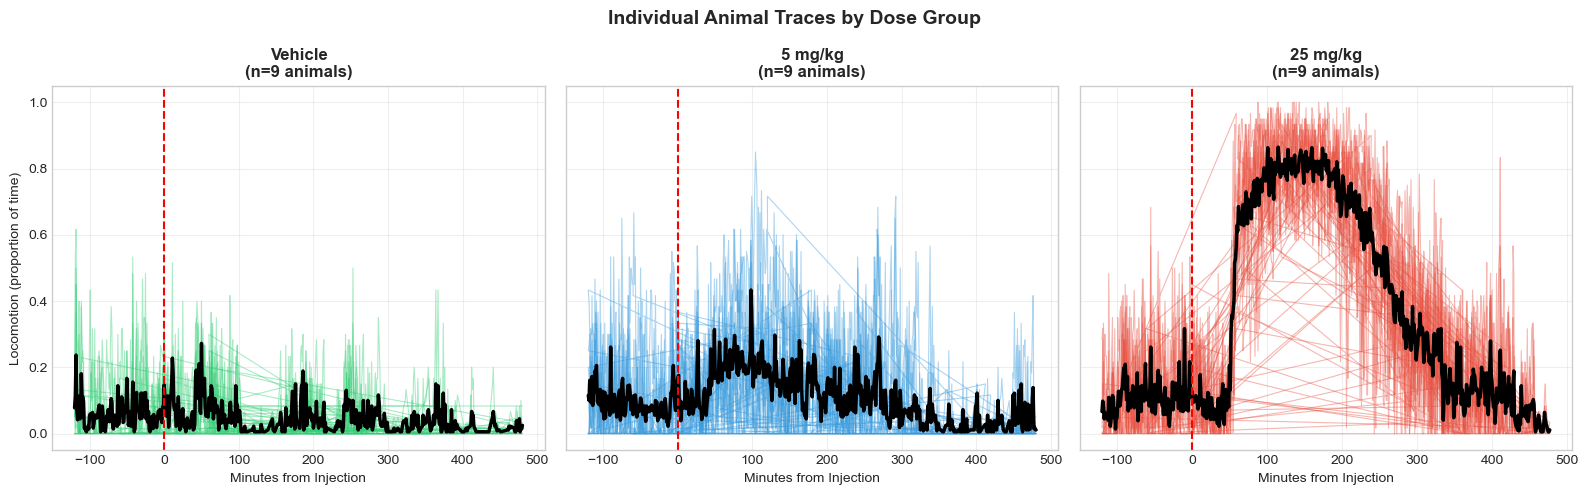

In [48]:
# ## Plot 2: Individual Animal Traces
# 
# See the variability within each dose group.

# %%
def plot_individual_traces(df):
    """Plot individual animal traces for each dose group."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
    
    colors = {
        'Vehicle': '#2ecc71',
        '5 mg/kg': '#3498db',
        '25 mg/kg': '#e74c3c'
    }
    
    dose_order = ['Vehicle', '5 mg/kg', '25 mg/kg']
    
    for idx, dose in enumerate(dose_order):
        ax = axes[idx]
        dose_data = df[df['dose_group'] == dose]
        
        # Plot each animal
        for animal_id in dose_data['animal_id'].unique():
            animal_data = dose_data[dose_data['animal_id'] == animal_id]
            ax.plot(animal_data['minutes_from_injection'], animal_data['value'],
                    color=colors[dose], alpha=0.4, linewidth=0.8)
        
        # Plot mean (thick black line)
        dose_data = dose_data.copy()
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        grouped = dose_data.groupby('time_bin')['value'].mean().reset_index()
        ax.plot(grouped['time_bin'], grouped['value'],
                color='black', linewidth=2.5, label='Mean')
        
        # Injection line
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
        
        ax.set_xlabel('Minutes from Injection')
        ax.set_title(f'{dose}\n(n={dose_data["animal_id"].nunique()} animals)', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.set_ylabel('Locomotion (proportion of time)')
    
    plt.suptitle('Individual Animal Traces by Dose Group', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig, axes

fig2, axes2 = plot_individual_traces(df_loco)
plt.show()

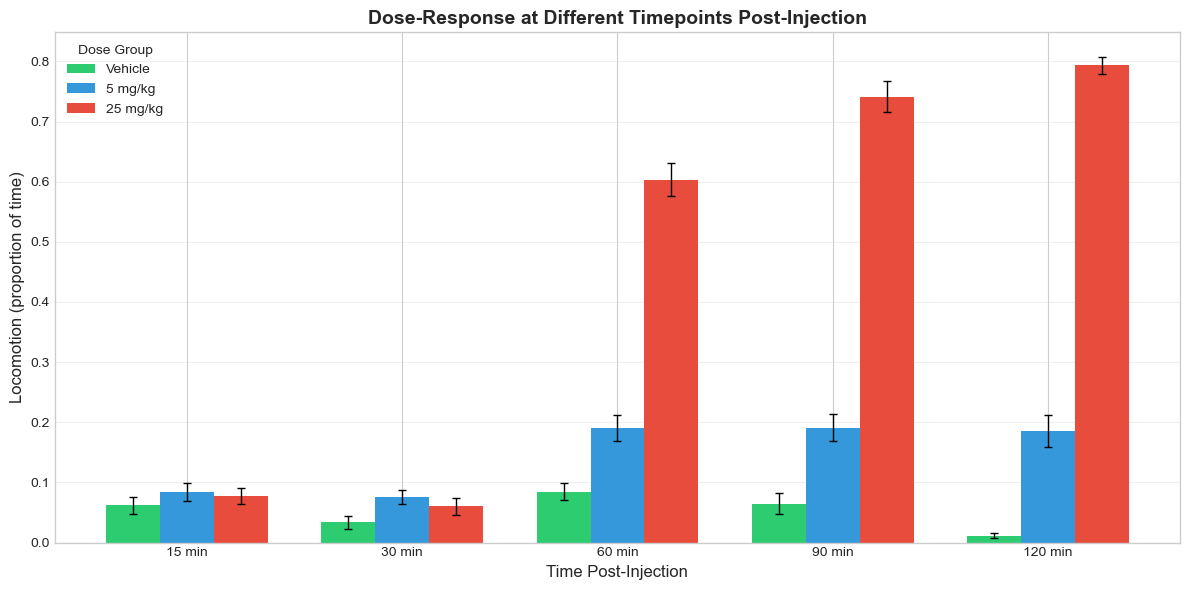

In [49]:
# ## Plot 3: Dose-Response at Specific Timepoints
# 
# Check if there's a clear dose-response gradient at different times post-injection.

# %%
def plot_dose_response_bars(df, timepoints=[15, 30, 60, 90, 120]):
    """Bar plot showing dose-response at specific timepoints."""
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = {
        'Vehicle': '#2ecc71',
        '5 mg/kg': '#3498db',
        '25 mg/kg': '#e74c3c'
    }
    
    dose_order = ['Vehicle', '5 mg/kg', '25 mg/kg']
    
    results = []
    for tp in timepoints:
        # Get data within ±2.5 minutes of timepoint (5-min window)
        window_data = df[
            (df['minutes_from_injection'] >= tp - 2.5) & 
            (df['minutes_from_injection'] <= tp + 2.5)
        ]
        
        for dose in dose_order:
            dose_data = window_data[window_data['dose_group'] == dose]['value']
            results.append({
                'timepoint': f'{tp} min',
                'dose': dose,
                'mean': dose_data.mean() if len(dose_data) > 0 else 0,
                'sem': dose_data.std() / np.sqrt(len(dose_data)) if len(dose_data) > 1 else 0,
                'n': len(dose_data)
            })
    
    results_df = pd.DataFrame(results)
    
    # Plot grouped bars
    x = np.arange(len(timepoints))
    width = 0.25
    
    for i, dose in enumerate(dose_order):
        dose_results = results_df[results_df['dose'] == dose]
        bars = ax.bar(x + (i - 1) * width, dose_results['mean'], width,
                      yerr=dose_results['sem'], label=dose, color=colors[dose],
                      capsize=3, error_kw={'linewidth': 1})
    
    ax.set_xlabel('Time Post-Injection', fontsize=12)
    ax.set_ylabel('Locomotion (proportion of time)', fontsize=12)
    ax.set_title('Dose-Response at Different Timepoints Post-Injection', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{tp} min' for tp in timepoints])
    ax.legend(title='Dose Group')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig, ax, results_df

fig3, ax3, dose_response_df = plot_dose_response_bars(df_loco)
plt.show()

In [50]:
print("\nDose-Response Summary:")
print(dose_response_df.pivot(index='timepoint', columns='dose', values='mean').round(4))



Dose-Response Summary:
dose       25 mg/kg  5 mg/kg  Vehicle
timepoint                            
120 min      0.7937   0.1852   0.0111
15 min       0.0770   0.0841   0.0617
30 min       0.0604   0.0756   0.0333
60 min       0.6033   0.1904   0.0842
90 min       0.7415   0.1907   0.0644


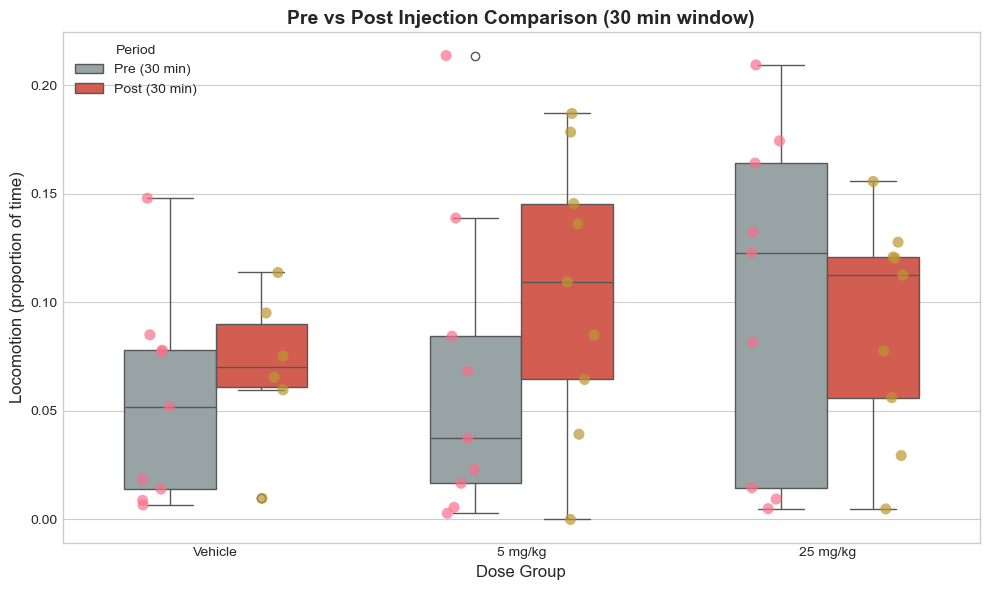

In [51]:
# ## Plot 4: Pre vs Post Comparison (Box Plot)
# 
# This is the core comparison for the Wilcoxon test.

# %%
def plot_pre_post_boxplot(df, window_minutes=30):
    """Box plot comparing pre vs post injection by dose group."""
    
    # Calculate mean value for each animal in pre and post windows
    pre_data = df[
        (df['minutes_from_injection'] >= -window_minutes) & 
        (df['minutes_from_injection'] < 0)
    ]
    post_data = df[
        (df['minutes_from_injection'] >= 0) & 
        (df['minutes_from_injection'] <= window_minutes)
    ]
    
    pre_means = pre_data.groupby(['animal_id', 'dose_group', 'cage_id'])['value'].mean().reset_index()
    pre_means['period'] = 'Pre (30 min)'
    
    post_means = post_data.groupby(['animal_id', 'dose_group', 'cage_id'])['value'].mean().reset_index()
    post_means['period'] = 'Post (30 min)'
    
    combined = pd.concat([pre_means, post_means])
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Box plot
    sns.boxplot(data=combined, x='dose_group', y='value', hue='period',
                order=['Vehicle', '5 mg/kg', '25 mg/kg'],
                palette={'Pre (30 min)': '#95a5a6', 'Post (30 min)': '#e74c3c'},
                ax=ax, width=0.6)
    
    # Overlay individual points with lines connecting pre/post for same animal
    sns.stripplot(data=combined, x='dose_group', y='value', hue='period',
                  order=['Vehicle', '5 mg/kg', '25 mg/kg'],
                  dodge=True, alpha=0.7, size=8, ax=ax, legend=False)
    
    ax.set_xlabel('Dose Group', fontsize=12)
    ax.set_ylabel('Locomotion (proportion of time)', fontsize=12)
    ax.set_title(f'Pre vs Post Injection Comparison ({window_minutes} min window)', 
                 fontsize=14, fontweight='bold')
    ax.legend(title='Period', loc='upper left')
    
    plt.tight_layout()
    return fig, ax, combined

fig4, ax4, comparison_df = plot_pre_post_boxplot(df_loco, window_minutes=30)
plt.show()


In [52]:
# ## Statistical Test: Wilcoxon Signed-Rank Test
# 
# For each dose group, test whether post-injection locomotion differs from pre-injection.

# %%
from scipy.stats import wilcoxon

def run_wilcoxon_tests(df, window_minutes=30):
    """Run Wilcoxon signed-rank tests for each dose group."""
    
    # Get pre/post means for each animal
    pre_data = df[
        (df['minutes_from_injection'] >= -window_minutes) & 
        (df['minutes_from_injection'] < 0)
    ]
    post_data = df[
        (df['minutes_from_injection'] >= 0) & 
        (df['minutes_from_injection'] <= window_minutes)
    ]
    
    pre_means = pre_data.groupby(['animal_id', 'dose_group'])['value'].mean()
    post_means = post_data.groupby(['animal_id', 'dose_group'])['value'].mean()
    
    results = []
    
    for dose in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        # Get paired data for this dose group
        pre_vals = pre_means.xs(dose, level='dose_group')
        post_vals = post_means.xs(dose, level='dose_group')
        
        # Align by animal_id
        common_animals = pre_vals.index.intersection(post_vals.index)
        pre_aligned = pre_vals[common_animals].values
        post_aligned = post_vals[common_animals].values
        
        # Run Wilcoxon test
        if len(pre_aligned) >= 3:  # Need at least 3 pairs
            stat, pval = wilcoxon(pre_aligned, post_aligned)
            
            # Effect size (rank-biserial correlation approximation)
            diff = post_aligned - pre_aligned
            effect_size = np.mean(diff) / np.std(diff) if np.std(diff) > 0 else 0
        else:
            stat, pval, effect_size = np.nan, np.nan, np.nan
        
        results.append({
            'dose_group': dose,
            'n_animals': len(common_animals),
            'pre_mean': pre_aligned.mean() if len(pre_aligned) > 0 else np.nan,
            'post_mean': post_aligned.mean() if len(post_aligned) > 0 else np.nan,
            'change': (post_aligned.mean() - pre_aligned.mean()) if len(pre_aligned) > 0 else np.nan,
            'wilcoxon_stat': stat,
            'p_value': pval,
            'effect_size_d': effect_size,
            'significant': pval < 0.05 if not np.isnan(pval) else False
        })
    
    return pd.DataFrame(results)

In [53]:
# Run the tests
stats_df = run_wilcoxon_tests(df_loco, window_minutes=30)

print("\n" + "=" * 70)
print("WILCOXON SIGNED-RANK TEST RESULTS (30-min window)")
print("=" * 70)
print(stats_df.to_string(index=False))

print("\n" + "-" * 70)
print("INTERPRETATION:")
print("-" * 70)
for _, row in stats_df.iterrows():
    sig = "✓ SIGNIFICANT" if row['significant'] else "✗ Not significant"
    print(f"{row['dose_group']:12s}: p = {row['p_value']:.4f} ({sig}), "
          f"change = {row['change']:+.4f}")


WILCOXON SIGNED-RANK TEST RESULTS (30-min window)
dose_group  n_animals  pre_mean  post_mean    change  wilcoxon_stat  p_value  effect_size_d  significant
   Vehicle          6  0.062667   0.069864  0.007197            8.0 0.687500       0.256699        False
   5 mg/kg          9  0.065645   0.105063  0.039418            8.0 0.097656       0.651735        False
  25 mg/kg          9  0.101531   0.089505 -0.012026           13.0 0.300781      -0.236475        False

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------
Vehicle     : p = 0.6875 (✗ Not significant), change = +0.0072
5 mg/kg     : p = 0.0977 (✗ Not significant), change = +0.0394
25 mg/kg    : p = 0.3008 (✗ Not significant), change = -0.0120


In [54]:
def estimate_effect_duration(df):
    """Estimate how long the morphine effect lasts."""
    
    # Get vehicle baseline (mean across all post-injection time)
    vehicle_baseline = df[
        (df['dose_group'] == 'Vehicle') & 
        (df['minutes_from_injection'] > 0)
    ]['value'].mean()
    
    vehicle_std = df[
        (df['dose_group'] == 'Vehicle') & 
        (df['minutes_from_injection'] > 0)
    ]['value'].std()
    
    print(f"Vehicle baseline: {vehicle_baseline:.4f} ± {vehicle_std:.4f}")
    
    # For 25 mg/kg, find when it returns to within 1 SD of vehicle baseline
    high_dose = df[df['dose_group'] == '25 mg/kg'].copy()
    high_dose['time_bin'] = (high_dose['minutes_from_injection'] // 10) * 10  # 10-min bins
    
    binned = high_dose[high_dose['minutes_from_injection'] > 0].groupby('time_bin')['value'].mean()
    
    threshold = vehicle_baseline + vehicle_std
    
    print(f"\n25 mg/kg locomotion over time (post-injection):")
    print("-" * 40)
    
    effect_ended = None
    for time_bin, value in binned.items():
        status = "ELEVATED" if value > threshold else "baseline"
        print(f"  {int(time_bin):3d}-{int(time_bin+10):3d} min: {value:.4f} ({status})")
        
        if value <= threshold and effect_ended is None:
            effect_ended = time_bin
    
    if effect_ended:
        print(f"\n→ Effect appears to end around {int(effect_ended)} minutes post-injection")
    else:
        print(f"\n→ Effect may persist beyond the analysis window")
    
    return effect_ended

effect_duration = estimate_effect_duration(df_loco)

Vehicle baseline: 0.0512 ± 0.0791

25 mg/kg locomotion over time (post-injection):
----------------------------------------
    0- 10 min: 0.0994 (baseline)
   10- 20 min: 0.0911 (baseline)
   20- 30 min: 0.0741 (baseline)
   30- 40 min: 0.0619 (baseline)
   40- 50 min: 0.0873 (baseline)
   50- 60 min: 0.3815 (ELEVATED)
   60- 70 min: 0.6496 (ELEVATED)
   70- 80 min: 0.6830 (ELEVATED)
   80- 90 min: 0.7315 (ELEVATED)
   90-100 min: 0.7648 (ELEVATED)
  100-110 min: 0.7713 (ELEVATED)
  110-120 min: 0.8061 (ELEVATED)
  120-130 min: 0.8015 (ELEVATED)
  130-140 min: 0.8104 (ELEVATED)
  140-150 min: 0.8144 (ELEVATED)
  150-160 min: 0.8211 (ELEVATED)
  160-170 min: 0.8057 (ELEVATED)
  170-180 min: 0.8183 (ELEVATED)
  180-190 min: 0.7811 (ELEVATED)
  190-200 min: 0.7439 (ELEVATED)
  200-210 min: 0.7185 (ELEVATED)
  210-220 min: 0.7026 (ELEVATED)
  220-230 min: 0.6398 (ELEVATED)
  230-240 min: 0.6269 (ELEVATED)
  240-250 min: 0.5361 (ELEVATED)
  250-260 min: 0.5141 (ELEVATED)
  260-270 min: 0.4